##### Install OpenCV

In [ ]:
!pip3 install opencv-python
!pip3 install boto3

##### Import libs needed below

In [1]:
# data processing
import pandas as pd 
# AWS
import boto3 
# OpenCV
import cv2
# file path
import os 
# plot img
from matplotlib import pyplot as plt 
# Numpy
import numpy as np 
# self defined functions
import commonfuns as cf
# seaborn
import seaborn as sns

In [18]:
# Show progress bar
from tqdm import tqdm 
# Apply progress bar to the DataFrame
tqdm.pandas()

##### Randomly select 2 heads from each celebrity

In [19]:
destination_path = 'headsets'
%rm -rf $destination_path
# Random select 5 pictures from each subdirectory of Test and copy them to headsets
cf.select_random_pictures('heads', destination_path, 2)

In [20]:
# Create a dataframe to store the image info
config = pd.DataFrame(columns=['name', 'path'])
# # Get all the folders under heads folder
sub_folder = cf.get_folders_under_path(destination_path)
# Get all the images under each folder
for f in sub_folder:
    names = f.split('/')[-1]
    for img in os.listdir(f):
        if img.endswith('.jpg') or img.endswith('.png'):
            path = os.path.join(f, img)
            config.loc[len(config)] = {'name': names, 'path': path}
# show the first 5 rows of the dataframe
config.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    300 non-null    object
 1   path    300 non-null    object
dtypes: object(2)
memory usage: 7.0+ KB


In [21]:
config.head()

,name,path
0,Sharon Stone,headsets/Sharon Stone/12.jpg
1,Sharon Stone,headsets/Sharon Stone/0.jpg
2,Keira Knightley,headsets/Keira Knightley/108.jpg
3,Keira Knightley,headsets/Keira Knightley/55.jpg
4,Nathan Lane,headsets/Nathan Lane/17.jpg


In [22]:
result_cofig = 'config.csv'
%rm -rf $result_cofig
config.to_csv(result_cofig, index=False)

##### Set up the Amazon Rekognition

In [23]:
from botocore.exceptions import ClientError

# Initialize the Amazon Rekognition client
AWS_ACCESS_KEY_ID ='AKIAJY2Q*********'
AWS_SECRET_ACCESS_KEY ='*********'
AWS_REGION = 'us-east-1'
rekognition_client = boto3.client('rekognition', 
                                  region_name=AWS_REGION, 
                                  aws_access_key_id=AWS_ACCESS_KEY_ID, 
                                  aws_secret_access_key=AWS_SECRET_ACCESS_KEY)

def amazon_celebrity_rekognition(cv_imag, rekognition_client = rekognition_client):
    # Convert the image to JPEG format
    _, jpeg_image = cv2.imencode('.jpg', cv_imag)
    jpeg_bytes = jpeg_image.tobytes()
    try:
        # Call the celebrity recognition API
        response = rekognition_client.recognize_celebrities(Image={'Bytes': jpeg_bytes})
    except ClientError as e:
        print('Something went wrong with rekognition: ' + e.to_string())
        return []
    else:
        return response['CelebrityFaces']

##### Feed original images to Amazon rekognition to test the recoginition rate

In [24]:
original_recog_rate = 'match'
config = cf.add_column(config, original_recog_rate, 0.0)
# Get the original celebrity recognition result
def recognize_original(row):
    image_path = row['path']
    image = cv2.imread(image_path)
    celebrities = amazon_celebrity_rekognition(image)
    if len(celebrities) > 0:
        row[original_recog_rate] = format( celebrities[0]['MatchConfidence'], '.2f')
    return row
# update the original celebrity recognition result to the config dataframe
config = config.progress_apply(recognize_original, axis=1)

100%|██████████| 300/300 [02:03<00:00,  2.43it/s]


In [25]:
config.head()

,name,path,match
0,Sharon Stone,headsets/Sharon Stone/12.jpg,99.68
1,Sharon Stone,headsets/Sharon Stone/0.jpg,99.98
2,Keira Knightley,headsets/Keira Knightley/108.jpg,77.93
3,Keira Knightley,headsets/Keira Knightley/55.jpg,98.70
4,Nathan Lane,headsets/Nathan Lane/17.jpg,99.83


In [26]:
config.to_csv(result_cofig, index=False) # Save the result to the config.csv file

In [238]:
# Add gaussian noise to image
# stddev: Standard deviation
def gaussian_noise(image, stddev = 0.5, intensity = 1):
    for _ in range(intensity):
        gaussian_noise = np.random.normal(0, stddev, image.shape).astype(np.uint8)
        image = cv2.add(image, gaussian_noise)
    return image

def gaussian_noise_recogize(row, column_name, intensity = 1, recog = False, stddev = 0.5, results = None):
    image_path = row['path']
    noisy_image = gaussian_noise(image = cv2.imread(image_path), stddev = stddev , intensity = intensity)
    if results is not None:
        results.append(noisy_image)
    if recog:
        celebrities = amazon_celebrity_rekognition(noisy_image)
        if len(celebrities) > 0:
            row[column_name] = format(celebrities[0]['MatchConfidence'], '.2f')
    return row

In [260]:
# drop_unnecessary_columns(config, ["gnmatch_7"])
# config.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   300 non-null    object
 1   path                   300 non-null    object
 2   match                  300 non-null    object
 3   leopard_1              300 non-null    object
 4   leopard_2              300 non-null    object
 5   leopard_3              300 non-null    object
 6   eyblack                300 non-null    object
 7   eywhite                300 non-null    object
 8   line_crossing_eyes_25  300 non-null    object
 9   line_crossing_eyes_35  300 non-null    object
 10  line_crossing_eyes_45  300 non-null    object
dtypes: object(11)
memory usage: 28.1+ KB


In [262]:
# Define different densities of gaussian noise    
intensities = [1,2,3,4,5,6,7,8]
for intensity in intensities:
    column_name = 'gnmatch_' + str(intensity)
    print(column_name)
    if column_name not in config.columns:
        cf.add_column(config, column_name, 0.0)
    config = config.progress_apply(gaussian_noise_recogize, axis=1,intensity =intensity, recog = True,  column_name = column_name, stddev=1)
    config.to_csv(result_cofig, index=False)

gnmatch_1


100%|██████████| 300/300 [02:06<00:00,  2.37it/s]


gnmatch_2


100%|██████████| 300/300 [02:06<00:00,  2.38it/s]


gnmatch_3


100%|██████████| 300/300 [02:05<00:00,  2.40it/s]


gnmatch_4


100%|██████████| 300/300 [01:59<00:00,  2.51it/s]


gnmatch_5


100%|██████████| 300/300 [01:45<00:00,  2.84it/s]


gnmatch_6


100%|██████████| 300/300 [01:29<00:00,  3.36it/s]


gnmatch_7


100%|██████████| 300/300 [01:27<00:00,  3.43it/s]


gnmatch_8


100%|██████████| 300/300 [01:29<00:00,  3.34it/s]


##### Add leopard spots and test the recognize rate

In [6]:
import random
# add leopard spots to an image
def add_leopard_spots(image, num_spots, spot_radius_range, spot_color):
    """Draws leopard spots on the image"""
    # Generate and draw leopard spots
    height, width = image.shape[:2]
    for _ in range(num_spots):
        spot_radius = random.randint(*spot_radius_range)
        spot_center = (random.randint(0, width), random.randint(0, height))
        cv2.circle(image, spot_center, spot_radius, spot_color, -1)
    return image

# Add leopard spots to image and feed the image to Amazon Rekognition row by row
def add_leopard_spots_recogize(row, column_name, num_spots, spot_radius_range, spot_color, recog = False, results = None):
    image_path = row['path']
    image = cv2.imread(image_path)
    image = add_leopard_spots(image, num_spots, spot_radius_range, spot_color)
    # If results is not None, append the image to the results list
    if results is not None:
        results.append(image)

    # If recognition is needed, call Amazon Rekognition
    if recog:
        celebrities = amazon_celebrity_rekognition(image)
        if len(celebrities) > 0:
            row[column_name] = format(celebrities[0]['MatchConfidence'], '.2f')
    return row

In [118]:
# Drop the unnecessary columns
def drop_unnecessary_columns(config, coloumns_to_drop):
    for col in coloumns_to_drop:
        if col in config.columns:
            config.drop(columns=[col], inplace=True)

In [220]:
config

,name,path,match,leopard_1,leopard_2,leopard_3,eyblack,eywhite,line_crossing_eyes_25,line_crossing_eyes_35,line_crossing_eyes_45
0,Sharon Stone,headsets/Sharon Stone/12.jpg,99.68,0.0,0.0,0.0,76.12,0.0,99.20,98.96,97.59
1,Sharon Stone,headsets/Sharon Stone/0.jpg,99.98,93.86,0.0,0.0,92.48,93.76,99.68,99.95,98.67
2,Keira Knightley,headsets/Keira Knightley/108.jpg,77.93,0.0,0.0,0.0,0.0,0.0,78.04,0.0,0.0
3,Keira Knightley,headsets/Keira Knightley/55.jpg,98.70,0.0,0.0,0.0,0.0,82.30,77.74,0.0,0.0
4,Nathan Lane,headsets/Nathan Lane/17.jpg,99.83,0.0,0.0,0.0,99.59,99.71,99.81,99.47,96.18
...,...,...,...,...,...,...,...,...,...,...,...
295,Jennifer Aniston,headsets/Jennifer Aniston/126.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,Mariah Carey,headsets/Mariah Carey/25.jpg,84.46,0.0,0.0,0.0,88.07,83.76,0.0,0.0,0.0
297,Mariah Carey,headsets/Mariah Carey/50.jpg,87.49,0.0,0.0,0.0,0.0,0.0,0.0,90.01,0.0
298,Nicolas Cage,headsets/Nicolas Cage/19.jpg,99.38,97.42,0.0,0.0,99.18,98.62,0.0,0.0,0.0


In [143]:
# Iterate over each row in the DataFrame and add leopard spots
###########################################
# Define the properties of the spots
spot_color = (0, 30, 0, 20)  # Spot color (BGR format)
num_spots = 70  # Number of spots to draw
base_radius = 4  # Base radius of the spots
###########################################
for i in range(1, 4):
    images = []
    column_name = 'leopard_' + str(i*1)
    print(column_name)
    if column_name not in config.columns:
        cf.add_column(config, column_name, 0.0)
    spot_radius_range = (base_radius * i, base_radius*(1+i))  # Ranege of spot radius
    config = config.progress_apply(add_leopard_spots_recogize, axis=1,column_name=column_name,num_spots=num_spots, 
                                    spot_radius_range=spot_radius_range, 
                                    spot_color=spot_color, recog = True, results=images)
    # cf.plot_multiple_images(1, 10, images)

leopard_1


100%|██████████| 300/300 [01:31<00:00,  3.27it/s]


leopard_2


100%|██████████| 300/300 [01:31<00:00,  3.29it/s]


leopard_3


100%|██████████| 300/300 [01:17<00:00,  3.85it/s]


In [145]:
# drop_unnecessary_columns(config, ['leopard_1', 'eyblack', 'eywhite'])
config

,name,path,match,gnmatch_2.8,gnmatch_3.1,gnmatch_3.4,gnmatch_3.7,gnmatch_4.0,gnmatch_4.3,gnmatch_4.6,gnmatch_4.9,leopard_1,leopard_2,leopard_3
0,Sharon Stone,headsets/Sharon Stone/12.jpg,99.68,79.63,0.0,0.0,0.0,0.0,78.23,0.0,0.0,0.0,0.0,0.0
1,Sharon Stone,headsets/Sharon Stone/0.jpg,99.98,92.91,77.37,0.0,0.0,0.0,0.0,0.0,0.0,93.86,0.0,0.0
2,Keira Knightley,headsets/Keira Knightley/108.jpg,77.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.99,0.0,0.0,0.0
3,Keira Knightley,headsets/Keira Knightley/55.jpg,98.70,0.0,0.0,76.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Nathan Lane,headsets/Nathan Lane/17.jpg,99.83,0.0,0.0,84.70,0.0,0.0,90.93,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,Jennifer Aniston,headsets/Jennifer Aniston/126.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.63,0.0,0.0,0.0,0.0
296,Mariah Carey,headsets/Mariah Carey/25.jpg,84.46,77.82,86.36,82.73,92.80,78.00,83.26,0.0,0.0,0.0,0.0,0.0
297,Mariah Carey,headsets/Mariah Carey/50.jpg,87.49,0.0,0.0,0.0,92.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,Nicolas Cage,headsets/Nicolas Cage/19.jpg,99.38,81.80,0.0,87.30,0.0,0.0,0.0,0.0,0.0,97.42,0.0,0.0


In [146]:
config.to_csv(result_cofig, index=False) # Save the result to the config.csv file

##### Block eyes

In [11]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

def eyes_blocking_recogize(row, column_name, recog = False, color=(0, 0, 0), results = None):
    image_path = row['path']
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=9, minSize=(30, 30))
    for (x, y, w, h) in eyes:
        cv2.rectangle(image, (x, y), (x+w, y+h), color, -1)
         
    if results is not None:
        results.append(image)
    if recog:
        celebrities = amazon_celebrity_rekognition(image)
       
        if len(celebrities) > 0:
            row[column_name] = format(celebrities[0]['MatchConfidence'], '.2f')
    return row

In [ ]:
column_names = ['eyblack', 'eywhite']
block_colors = [(0, 0, 0), (255, 255, 255)]

for i, column_name in enumerate(column_names):
    images = []
    if column_name not in config.columns:
        cf.add_column(config, column_name, 0.0)  
    config = config.progress_apply(eyes_blocking_recogize, axis=1, column_name = column_name, recog = True, color = block_colors[i])

In [149]:
config.to_csv(result_cofig, index=False) # Save the result to the config.csv file

In [219]:
config

,name,path,match,leopard_1,leopard_2,leopard_3,eyblack,eywhite,line_crossing_eyes_25,line_crossing_eyes_35,line_crossing_eyes_45
0,Sharon Stone,headsets/Sharon Stone/12.jpg,99.68,0.0,0.0,0.0,76.12,0.0,99.20,98.96,97.59
1,Sharon Stone,headsets/Sharon Stone/0.jpg,99.98,93.86,0.0,0.0,92.48,93.76,99.68,99.95,98.67
2,Keira Knightley,headsets/Keira Knightley/108.jpg,77.93,0.0,0.0,0.0,0.0,0.0,78.04,0.0,0.0
3,Keira Knightley,headsets/Keira Knightley/55.jpg,98.70,0.0,0.0,0.0,0.0,82.30,77.74,0.0,0.0
4,Nathan Lane,headsets/Nathan Lane/17.jpg,99.83,0.0,0.0,0.0,99.59,99.71,99.81,99.47,96.18
...,...,...,...,...,...,...,...,...,...,...,...
295,Jennifer Aniston,headsets/Jennifer Aniston/126.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,Mariah Carey,headsets/Mariah Carey/25.jpg,84.46,0.0,0.0,0.0,88.07,83.76,0.0,0.0,0.0
297,Mariah Carey,headsets/Mariah Carey/50.jpg,87.49,0.0,0.0,0.0,0.0,0.0,0.0,90.01,0.0
298,Nicolas Cage,headsets/Nicolas Cage/19.jpg,99.38,97.42,0.0,0.0,99.18,98.62,0.0,0.0,0.0


#### Line through eyes

In [9]:
# Calculate the angle of a line
def calculate_angle_of_line(start_point, end_point):
    # Calculate the differences in x and y coordinates
    delta_x = end_point[0] - start_point[0]
    delta_y = end_point[1] - start_point[1]

    # Calculate the angle in radians using arctan2
    angle_rad = np.arctan2(delta_y, delta_x)

    # Convert the angle to degrees
    # angle_deg = np.rad2deg(angle_rad)
    return angle_rad

# Draw a rectangle along a line
def draw_rectangle_along_line(image,w, h, ls, le):
    angle = calculate_angle_of_line(ls, le)
    # Define the rotation matrix
    center_x = (ls[0] + le[0]) / 2.0
    center_y = (ls[1] + le[1]) / 2.0
    center_point = (center_x, center_y)
    rotation_matrix = cv2.getRotationMatrix2D(center_point, angle, 1.0)
    
    # Define the corner points of the rectangle
    corners = np.array([[-w/2, -h/2], [w/2, -h/2], [w/2, h/2], [-w/2, h/2]])
    # Rotate the corner points
    rotated_corners = cv2.transform(np.array([corners]), rotation_matrix)[0]
    # Shift the rotated corners to the center position
    rotated_corners[:, 0] += center_x
    rotated_corners[:, 1] += center_y
    # Draw the rotated solid rectangle
    cv2.fillPoly(image, [np.int32(rotated_corners)], (0, 255, 0))
    
# Apply this to each row
def line_crossing_eyes_recognize(row, column_name, height = 20, recog = False, results = None):
    image_path = row['path']
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5, minSize=(30, 30))
    # the number of eyes detected is less than 2
    if len(eyes) >= 2:
        # Draw a rectangle along the line between the eyes
        rec1 = (eyes[0][0], eyes[0][1], eyes[0][2], eyes[0][3])
        rec2 = (eyes[1][0], eyes[1][1], eyes[1][2], eyes[1][3])
    
        center_r1 = (rec1[0] + rec1[2] // 2, rec1[1] + rec1[3] // 2)
        center_r2 = (rec2[0] + rec2[2] // 2, rec2[1] + rec2[3] // 2)
    
        distance = np.sqrt((center_r1[0] - center_r2[0])**2 + (center_r1[1] - center_r2[1])**2)
        draw_rectangle_along_line(image, distance * 1.6, height,  center_r1, center_r2)
        if recog: 
            celebrities = amazon_celebrity_rekognition(image)
            if len(celebrities) > 0:
                row[column_name] = format(celebrities[0]['MatchConfidence'], '.2f')
    if results is not None:
        results.append(image)
    return row

In [ ]:
heights = [25, 35, 45]

for h in heights:
    images = []
    column_name = 'line_crossing_eyes_' + str(h)
    print(column_name)
    if column_name not in config.columns:
        cf.add_column(config, column_name, 0.0)  
    config = config.progress_apply(line_crossing_eyes_recognize, axis=1,recog = True, column_name = column_name, height = h, results=images)

##### Plot the results in different methods

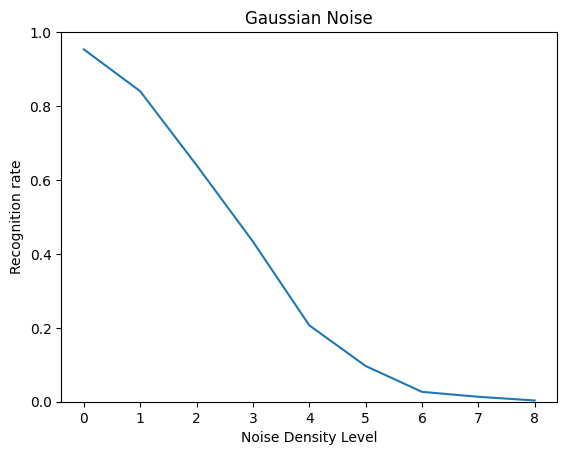

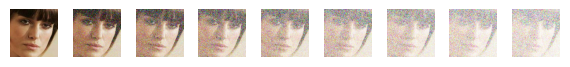

In [278]:
column_names = ["match", "gnmatch_1",	"gnmatch_2", "gnmatch_3","gnmatch_4",
                "gnmatch_5","gnmatch_6","gnmatch_7","gnmatch_8"]
accuracies = [cf.compute_accuracy(config, cft, 40) for cft in column_names]
# Plot the accuracy curve
plt.plot([0, 1, 2, 3, 4, 5, 6, 7, 8], accuracies)
# Set the x-axis label and y-axis label
plt.xlabel('Noise Density Level')
plt.ylabel('Recognition rate')
# Set the title of the plot
plt.title('Gaussian Noise')
# Set the y-axis limits
plt.ylim(0, 1)
# Display the plot
# plt.xlim([0, 4.9] )
plt.show()

images = []
intensities = np.arange(0, 9, 1)
for intensity in intensities:
    config.iloc[2:3].apply(gaussian_noise_recogize, axis=1,intensity =intensity,  column_name = "", stddev=1, results=images)
cf.plot_multiple_images(1, 9, images,(5.8,5.8))

In [3]:
config = pd.read_csv('config.csv')

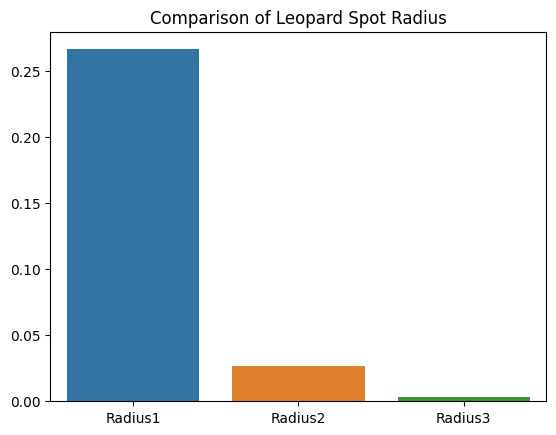

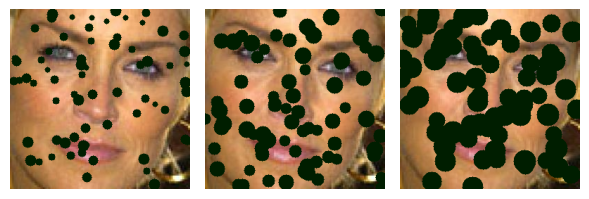

In [7]:
sns.barplot(x=np.array(['Radius1', 'Radius2','Radius3']),
            y=np.array([len(config[config['leopard_1'] >20])/ len(config), 
                        len(config[config['leopard_2'] >20] ) / len(config),
                        len(config[config['leopard_3'] >20]) / len(config)]))
plt.title('Comparison of Leopard Spot Radius')

# Iterate over each row in the DataFrame and add leopard spots
###########################################
# Define the properties of the spots
spot_color = (0, 30, 0, 20)  # Spot color (BGR format)
num_spots = 70  # Number of spots to draw
base_radius = 4  # Base radius of the spots
###########################################
images = []
for i in range(1, 4):
    spot_radius_range = (base_radius * i, base_radius*(1+i))  # Ranege of spot radius
    config.iloc[1:2].apply(add_leopard_spots_recogize, axis=1,column_name='',num_spots=num_spots, 
                                    spot_radius_range=spot_radius_range, 
                                    spot_color=spot_color, recog = False, results=images)
cf.plot_multiple_images(1, 3, images,(6,6))

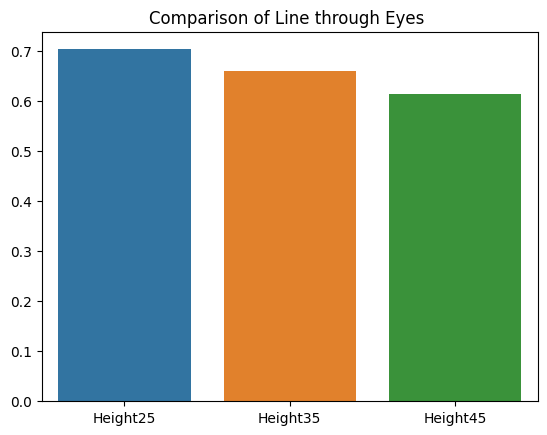

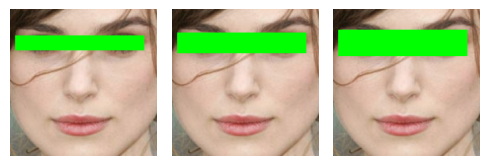

In [14]:
# config.info()
# line_crossing_eyes_25, line_crossing_eyes_35, line_crossing_eyes_45 
sns.barplot(x=np.array(['Height25', 'Height35','Height45']),
            y=np.array([len(config[config['line_crossing_eyes_25'] >30]) / len(config), 
                        len(config[config['line_crossing_eyes_35'] >30]) / len(config),
                        len(config[config['line_crossing_eyes_45'] >30]) / len(config)]))
plt.title('Comparison of Line through Eyes ')


heights = [25, 35, 45]
images = []
for h in heights:
    config.iloc[3:4].apply(line_crossing_eyes_recognize, axis=1,recog = False, column_name = '', height = h, results=images)
cf.plot_multiple_images(1, 3, images,(5,5))


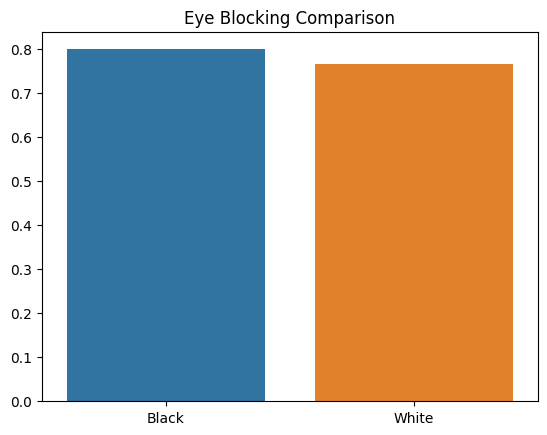

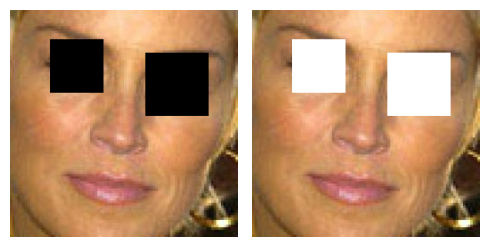

In [16]:

column_names = ['eyblack', 'eywhite']
block_colors = [(0, 0, 0), (255, 255, 255)]


sns.barplot(x=np.array(['Black','White']),
            y=np.array([len(config[config['eyblack'] > 30] ) / len(config), 
                        len(config[config['eywhite'] > 30]) / len(config)]))
plt.title('Eye Blocking Comparison')

images = []
for i, column_name in enumerate(column_names):
    config.iloc[1:2].apply(eyes_blocking_recogize, axis=1, column_name = '', recog = False, color = block_colors[i], results=images)
cf.plot_multiple_images(1, 2, images, (5,5))